# DDoS Network Intrusion Detection and Classification

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
pwd

In [ ]:
# This extension for sound notification and cell completion time
get_ipython().magic('load_ext cellevents')

## Loading dataframe with all attacks

In [6]:
# Data with 0.20 of each attack 1.0 of benign flows
df = pd.read_csv('mydata/all_df2.csv')

time: 20.3 s


In [ ]:
# Data after EDA
df_clean = pd.read_csv('mydata/all_dfclean.csv')

In [6]:
# Run df for EDA and complete notebook
#all_df = df.copy()

time: 282 µs


In [ ]:
# Run df_clean for running models and further anlyses
all_df = df_clean.copy()

time: 84.6 ms


### EDA

In [85]:
all_df.head(2)

,Unnamed: 0,Unnamed: 0.1,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,2141543,7652,172.16.0.5-192.168.50.1-47827-47090-17,172.16.0.5,47827,192.168.50.1,47090,17,2018-12-01 13:04:42.030242,981829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP
1,1833555,16041,172.16.0.5-192.168.50.1-50388-43249-17,172.16.0.5,50388,192.168.50.1,43249,17,2018-12-01 12:59:00.749867,218355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP


time: 93.7 ms


In [86]:
all_df.shape

(2386803, 89)

time: 7.07 ms


In [87]:
# Classification labels for dependent variable 
classes_names = all_df[' Label'].unique()

time: 121 ms


In [88]:
# Assigning numeric values for classification variable 
all_df = all_df.replace({' Label': {'DrDoS_MSSQL':1, 'DrDoS_LDAP':2, 'DrDoS_NetBIOS':3, 'Syn':4,
       'DrDoS_UDP':5, 'BENIGN':0}})

time: 3.79 s


In [89]:
# Converting to type int
all_df[' Label'].astype(int)
pd.set_option('display.min_rows', None)

time: 8.16 ms


In [90]:
# Shuffling rows 
all_df = all_df.sample(frac=1)

time: 8.65 s


In [91]:
# Checking unbalance
all_df[' Label'].value_counts()

3    818656
5    626929
2    435986
4    316458
1    180900
0      7874
Name:  Label, dtype: int64

time: 61.9 ms


In [92]:
# Finding variables datatypes
pd.set_option('display.max_rows', None)
all_df.dtypes

Unnamed: 0                        int64
Unnamed: 0.1                      int64
Flow ID                          object
 Source IP                       object
 Source Port                      int64
 Destination IP                  object
 Destination Port                 int64
 Protocol                         int64
 Timestamp                       object
 Flow Duration                    int64
 Total Fwd Packets                int64
 Total Backward Packets           int64
Total Length of Fwd Packets     float64
 Total Length of Bwd Packets    float64
 Fwd Packet Length Max          float64
 Fwd Packet Length Min          float64
 Fwd Packet Length Mean         float64
 Fwd Packet Length Std          float64
Bwd Packet Length Max           float64
 Bwd Packet Length Min          float64
 Bwd Packet Length Mean         float64
 Bwd Packet Length Std          float64
Flow Bytes/s                     object
 Flow Packets/s                  object
 Flow IAT Mean                  float64


time: 9.06 ms


In [93]:
# Dropping non numeric identifiers 
all_df = all_df.drop(columns=['Unnamed: 0','Unnamed: 0.1','Flow ID', ' Source IP', ' Timestamp',
       ' Destination IP', 'SimillarHTTP'])

time: 2.09 s


In [94]:
# Converting flow packets to float (was object)
all_df[' Flow Packets/s']= all_df[' Flow Packets/s'].astype(float)

# Converting flow bytes to float (was object)
all_df['Flow Bytes/s']= all_df['Flow Bytes/s'].astype(float)

time: 884 ms


In [95]:
# Maximum value 
all_df[' Flow Packets/s'].max()

inf

time: 30.6 ms


In [96]:
# Number of infinity values 
all_df[' Flow Packets/s'].loc[all_df[' Flow Packets/s'] == np.inf].count()

87146

time: 54.2 ms


In [97]:
# Maximum value 
all_df['Flow Bytes/s'].max()

inf

time: 16.4 ms


In [98]:
# Number of infinity values 
all_df['Flow Bytes/s'].loc[all_df['Flow Bytes/s'] == np.inf].count()

46848

time: 7.61 ms


In [99]:
# Finding nans
all_df[' Flow Packets/s'].isna().sum()

0

time: 10.1 ms


In [100]:
# Finding max value thats not infinity and assigning it to inf
max_bytes = all_df.loc[all_df['Flow Bytes/s'] != np.inf, 'Flow Bytes/s'].max()
all_df['Flow Bytes/s'].replace(np.inf,max_bytes,inplace=True)

time: 65.7 ms


In [101]:
# Finding max value thats not infinity and assigning it to inf
max_packets = all_df.loc[all_df[' Flow Packets/s'] != np.inf, ' Flow Packets/s'].max()
all_df[' Flow Packets/s'].replace(np.inf,max_packets,inplace=True)

time: 28.3 ms


In [102]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

40298

time: 6.19 ms


In [103]:
# 'Flow Bytes/s' has all of dfs nans
pd.set_option('display.max_rows', None)
all_df.isna().sum()

 Source Port                        0
 Destination Port                   0
 Protocol                           0
 Flow Duration                      0
 Total Fwd Packets                  0
 Total Backward Packets             0
Total Length of Fwd Packets         0
 Total Length of Bwd Packets        0
 Fwd Packet Length Max              0
 Fwd Packet Length Min              0
 Fwd Packet Length Mean             0
 Fwd Packet Length Std              0
Bwd Packet Length Max               0
 Bwd Packet Length Min              0
 Bwd Packet Length Mean             0
 Bwd Packet Length Std              0
Flow Bytes/s                    40298
 Flow Packets/s                     0
 Flow IAT Mean                      0
 Flow IAT Std                       0
 Flow IAT Max                       0
 Flow IAT Min                       0
Fwd IAT Total                       0
 Fwd IAT Mean                       0
 Fwd IAT Std                        0
 Fwd IAT Max                        0
 Fwd IAT Min

time: 1.21 s


In [104]:
# 'Flow Bytes/s' quick stats
all_df['Flow Bytes/s'].describe()

count    2.346505e+06
mean     7.623327e+08
std      9.627836e+08
min      0.000000e+00
25%      1.380144e+04
50%      4.580000e+08
75%      8.160000e+08
max      2.944000e+09
Name: Flow Bytes/s, dtype: float64

time: 97.9 ms


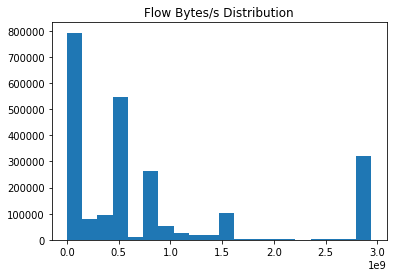

time: 464 ms


In [105]:
# 'Flow Bytes/s' distribution
plt.figure()
plt.hist(all_df['Flow Bytes/s'], bins=20)
plt.title('Flow Bytes/s Distribution')
plt.show()

In [106]:
# Which class has null values
g = all_df.groupby(' Label')
g = g.count().rsub(g.size(), axis=0)
g['Flow Bytes/s']

 Label
0       32
1        1
2        0
3        1
4    40264
5        0
Name: Flow Bytes/s, dtype: int64

time: 2.14 s


In [107]:
# This takes a bit
# Filling nans with medians of each class
all_df['Flow Bytes/s'] = all_df.groupby(" Label").transform(lambda x: x.fillna(x.median()))

time: 20 s


In [108]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

0

time: 12 ms


### Defining variables

In [19]:
# Defining vaariables 
X = all_df.iloc[:,:-1]
y = all_df.iloc[:,-1]

time: 643 ms


In [110]:
# This takes a bit to run
# Applying Lasso regression
lasso_all_df = Lasso()
lasso_all_df.fit(X,y)

#lasso_all_df.coef_

array([ 6.34349670e-06,  8.44767582e-07, -0.00000000e+00,  1.12001508e-08,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  2.97612108e-06,
        1.68159992e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.72804716e-04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        1.11660980e-05, -7.02479087e-08,  8.26145092e-08,  1.20593121e-07,
        1.93013862e-08, -7.69755188e-06, -1.25906925e-08,  5.57478081e-08,
        7.22221937e-10,  6.44110963e-08,  7.18214063e-06, -2.85357338e-08,
       -9.17031074e-08, -5.93806007e-08,  9.36393333e-08, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.07202049e-11,  2.03327191e-09, -9.05615962e-08, -2.52725414e-06,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.00944118e-06,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

time: 2min 22s


In [111]:
# Creating dataframe for lasso coeffs
a = [X.columns, lasso_all_df.coef_]
df_lasso = pd.DataFrame(a).T

time: 13.5 ms


In [112]:
# Renaming columns
df_lasso = df_lasso.rename(columns={0:'variables', 1:'coeff'})

time: 4.03 ms


In [113]:
# Sorting 
df_lasso.sort_values(by='coeff', ascending=False)

,variables,coeff
55,Avg Fwd Segment Size,0.0032166
8,Fwd Packet Length Max,0.0016816
65,Subflow Fwd Bytes,0.000115033
16,Flow Bytes/s,1.11661e-05
26,Fwd IAT Min,7.18214e-06
0,Source Port,6.3435e-06
7,Total Length of Bwd Packets,2.97612e-06
1,Destination Port,8.44768e-07
73,Active Std,6.12485e-07
19,Flow IAT Std,1.20593e-07


time: 15.8 ms


In [114]:
# Assignig zero coefficients 
zero_coeffs = df_lasso[df_lasso.coeff == 0]

# Values of zero lasso coefficients
zero_coeffs['variables'].values

array([' Protocol', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', 'FIN Flag Count', ' SYN Flag Count',
       ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count',
       ' Down/Up Ratio', ' Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
       ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Bwd Packets',
       ' Subflow Bwd Bytes', ' act_data_pkt_fwd', ' Inbound'],
      dtype=object)

time: 4.87 ms


In [115]:
# Dropping zero coefficient variables
all_df = all_df.drop(columns=[' Protocol', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std',
       ' Fwd IAT Min', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Min Packet Length',
       ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std',
       'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count',
       ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count',
       ' CWE Flag Count', ' ECE Flag Count', ' Down/Up Ratio',
       ' Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
       ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Bwd Packets',
       ' Subflow Bwd Bytes', ' act_data_pkt_fwd', ' Inbound'])

time: 1.04 s


In [116]:
all_df.shape

(2386803, 40)

time: 2.38 ms


In [117]:
# Destination Port and Source Port will be dropped as they're both identifier variables 
# Including them in model would result in data leakage
all_df = all_df.drop(columns=[' Destination Port', ' Source Port'])

time: 458 ms


In [9]:
# Reassigning X
X = all_df.iloc[:,:-1]
y = all_df.iloc[:,-1]

time: 450 ms


### Splitting data

In [60]:
# Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=1)

time: 7.55 s


### My first DT - unbalanced data

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

time: 796 µs


In [121]:
# This takes long
# GridSearch for decision tree classifier 
params = {'max_depth':[5,10,15,20]}

grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5)

grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.99
Best parameters:  {'max_depth': 15}
Best estimator:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
time: 5min 6s


In [164]:
# Instating moodel
my_DT = DecisionTreeClassifier(max_depth=15)
my_DT.fit(X_train,y_train)
print(f'Score on train: {my_DT.score(X_train, y_train)}')
print(f'Score on test: {my_DT.score(X_test, y_test)}')

Score on train: 0.9937358662897328
Score on test: 0.9928398004864243
time: 25.3 s


In [165]:
# Creating a dataframe for gini feature importance 
feat_imp=[X.columns, my_DT.feature_importances_]
df_feat_imp =pd.DataFrame(feat_imp).T
df_feat_imp = df_feat_imp.rename(columns= {0:'Variables', 1:'Gini_Importance'})

time: 13.4 ms


In [166]:
# Head of top features 
df_featimp = df_feat_imp.sort_values(by='Gini_Importance', ascending=False).head(5)

time: 3.91 ms


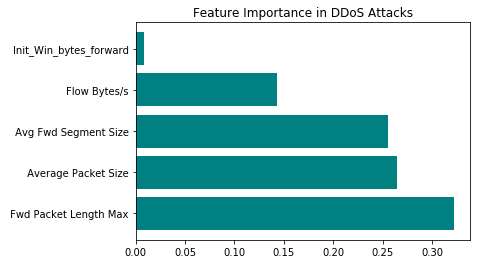

time: 169 ms


In [167]:
# Plot for feature importance
plt.figure()
plt.barh(df_featimp['Variables'], df_featimp['Gini_Importance'] , color = 'teal')
plt.title("Feature Importance in DDoS Attacks")
plt.show()

In [168]:
from sklearn.metrics import confusion_matrix
# Defining y predict

y_pred = my_DT.predict(X_test)
from sklearn.metrics import confusion_matrix

# Confusion mastrix
confusion_matrix(y_test, y_pred)

array([[  1567,      3,      0,      0,      0,      5],
       [     1,  35133,    188,    214,      1,    643],
       [     0,     34,  87126,      3,      3,     31],
       [     2,   1651,      4, 161986,      2,     86],
       [     1,      0,      1,      2,  63285,      3],
       [     1,    491,     35,     10,      3, 124846]])

time: 494 ms


In [169]:
# Creating c olor gradient dataframe for confusion matrix
con_mat = confusion_matrix(y_test, y_pred) 
df_conmat = pd.DataFrame(con_mat, columns=['Predictec Class 0', 'Predicted Class 1','Predicted Class 2','Predicted Class 3','Predicted Class 4','Predicted Class 5'] )
df_conmat = df_conmat.rename('True {}'.format)
df_conmat.style.background_gradient(cmap='GnBu')

,Predictec Class 0,Predicted Class 1,Predicted Class 2,Predicted Class 3,Predicted Class 4,Predicted Class 5
True 0,1567,3,0,0,0,5
True 1,1,35133,188,214,1,643
True 2,0,34,87126,3,3,31
True 3,2,1651,4,161986,2,86
True 4,1,0,1,2,63285,3
True 5,1,491,35,10,3,124846


time: 343 ms


In [170]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1575
           1       0.94      0.97      0.96     36180
           2       1.00      1.00      1.00     87197
           3       1.00      0.99      0.99    163731
           4       1.00      1.00      1.00     63292
           5       0.99      1.00      0.99    125386

    accuracy                           0.99    477361
   macro avg       0.99      0.99      0.99    477361
weighted avg       0.99      0.99      0.99    477361

time: 572 ms


### My second DT - Resampled balanced data

time: 506 µs


In [61]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Undersampling for more managable data
print('Original dataset shape %s' % Counter(y_train))
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({'3': 654925, '5': 501543, '2': 348789, '4': 253166, '1': 144720, '0': 6299})
Resampled dataset shape Counter({'0': 6299, '1': 6299, '2': 6299, '3': 6299, '4': 6299, '5': 6299})
time: 32.8 s


In [173]:
# GridSearch for second decision tree classifier 
params = {'max_depth':[5,10,15,20]}

grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5)

grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.99
Best parameters:  {'max_depth': 5}
Best estimator:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
time: 2.61 s


In [132]:
# DT for balanced train data
my_DT2 = DecisionTreeClassifier(max_depth=10)
my_DT2.fit(X_train,y_train)
print(f'Score on train: {my_DT2.score(X_train, y_train)}')
print(f'Score on test: {my_DT2.score(X_test, y_test)}')

Score on train: 0.9939937556225856
Score on test: 0.9900096572614855
time: 301 ms


In [209]:
# New feature importance dataframe
feat_imp2 = [X.columns, my_DT2.feature_importances_]
df_featimp2 = pd.DataFrame(feat_imp).T
df_featimp2 = df_featimp2.rename(columns= {0:'Variables', 1:'Gini_Importance'})
df_featimp2 = df_featimp2.sort_values(by='Gini_Importance', ascending=False).head()
df_featimp2

,Variables,Gini_Importance
23,Avg Fwd Segment Size,0.398212
3,Flow Bytes/s,0.201081
26,Init_Win_bytes_forward,0.199898
22,Average Packet Size,0.190235
5,Flow IAT Mean,0.00521351


time: 16.4 ms


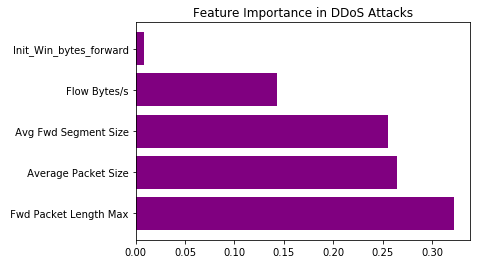

time: 119 ms


In [177]:
# Feature importance plot for DT2
plt.figure()
plt.barh(df_featimp2['Variables'], df_featimp2['Gini_Importance'] , color = 'purple')
plt.title("Feature Importance in DDoS Attacks")
plt.show()

In [181]:
# Defining y predict
y_pred2 = my_DT2.predict(X_test)
from sklearn.metrics import confusion_matrix

# Confusion mastrix
confusion_matrix(y_test, y_pred2)

array([[  1574,      0,      0,      0,      1,      0],
       [     5,  35616,    183,    106,      0,    270],
       [    18,    164,  86961,     10,      3,     41],
       [    47,   2000,      8, 161639,      2,     35],
       [    12,     10,      0,      0,  63267,      3],
       [   109,   1632,     95,      8,      7, 123535]])

time: 454 ms


In [182]:
# Creating color gradient dataframe for confusion matrix
con_mat = confusion_matrix(y_test, y_pred2) 
df_conmat = pd.DataFrame(con_mat, columns=['Predictec Class 0', 'Predicted Class 1','Predicted Class 2','Predicted Class 3','Predicted Class 4','Predicted Class 5'] )
df_conmat = df_conmat.rename('True {}'.format)
df_conmat.style.background_gradient(cmap='BuPu')

,Predictec Class 0,Predicted Class 1,Predicted Class 2,Predicted Class 3,Predicted Class 4,Predicted Class 5
True 0,1574,0,0,0,1,0
True 1,5,35616,183,106,0,270
True 2,18,164,86961,10,3,41
True 3,47,2000,8,161639,2,35
True 4,12,10,0,0,63267,3
True 5,109,1632,95,8,7,123535


time: 344 ms


In [190]:
# Classification report for DT2
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1575
           1       0.90      0.98      0.94     36180
           2       1.00      1.00      1.00     87197
           3       1.00      0.99      0.99    163731
           4       1.00      1.00      1.00     63292
           5       1.00      0.99      0.99    125386

    accuracy                           0.99    477361
   macro avg       0.96      0.99      0.98    477361
weighted avg       0.99      0.99      0.99    477361

time: 559 ms


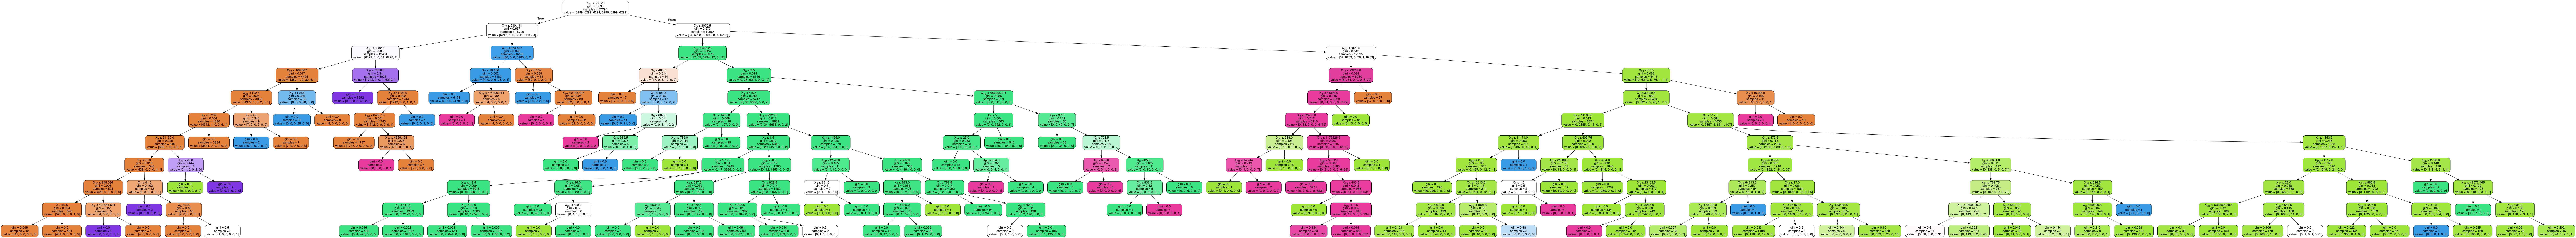

time: 3.78 s


In [184]:
# DT2 tree plot
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data2 = StringIO()

export_graphviz(my_DT2, out_file=dot_data2,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### DT3 - max_depth = 5

In [203]:
# DT3 with mmax depth 5
my_DT3 = DecisionTreeClassifier(max_depth=5)
my_DT3.fit(X_train,y_train)
print(f'Score on train: {my_DT3.score(X_train, y_train)}')
print(f'Score on test: {my_DT3.score(X_test, y_test)}')

Score on train: 0.9923532835899879
Score on test: 0.989234562521865
time: 302 ms


In [204]:
# Defining y predict
y_pred3 = my_DT3.predict(X_test)
from sklearn.metrics import confusion_matrix

# Confusion mastrix
confusion_matrix(y_test, y_pred3)

array([[  1575,      0,      0,      0,      0,      0],
       [     6,  35773,    186,      0,      0,    215],
       [    21,     55,  87120,      0,      1,      0],
       [   117,   2043,     16, 161533,      0,     22],
       [    32,     10,      3,      0,  63247,      0],
       [   115,   2087,    201,      8,      1, 122974]])

time: 438 ms


In [205]:
# Classification report
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92      1575
           1       0.90      0.99      0.94     36180
           2       1.00      1.00      1.00     87197
           3       1.00      0.99      0.99    163731
           4       1.00      1.00      1.00     63292
           5       1.00      0.98      0.99    125386

    accuracy                           0.99    477361
   macro avg       0.96      0.99      0.97    477361
weighted avg       0.99      0.99      0.99    477361

time: 570 ms


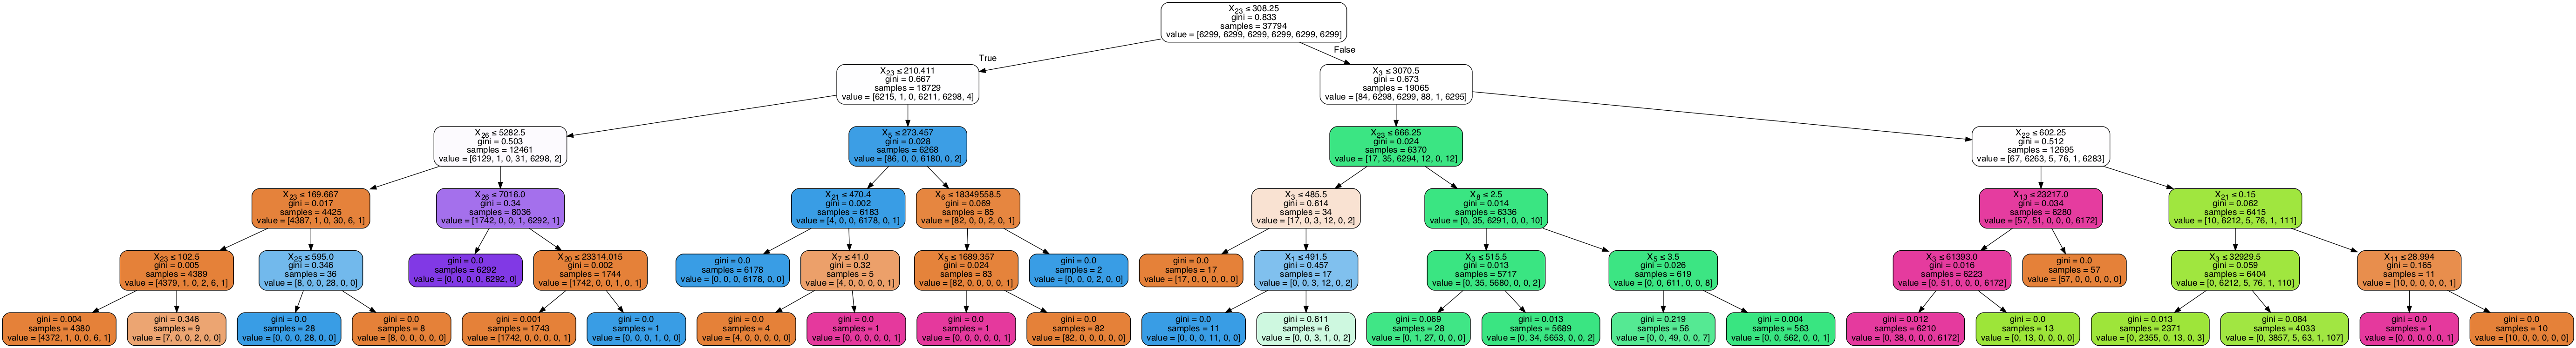

time: 1.38 s


In [206]:
# DT3 plot max depth 5
dot_data3 = StringIO()

export_graphviz(my_DT3, out_file=dot_data3,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### My 1st logistic regression

In [138]:
# Searching optimal hyperparameters
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
            ,'penalty': ['l1','l2']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.33
Best parameters:  {'C': 100, 'penalty': 'l2'}
Best estimator:  LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
time: 27.6 s


In [139]:
my_logreg = LogisticRegression(C=100)
my_logreg.fit(X_train,y_train)
print(f'Score on train: {my_logreg.score(X_train, y_train)}')
print(f'Score on test: {my_logreg.score(X_test, y_test)}')

Score on train: 0.32301423506376675
Score on test: 0.3646799801408159
time: 944 ms


In [ ]:
# Pickling top model for reuse
import joblib
joblib.dump(my_DT2, 'my_dt2.pkl')